# YAMNet for audio music classification
This program is a simple re-use of YAMNet for a project in a "music and technologie" courses.

## Import TensorFlow, ffmpeg and other libraries
[TensorFlow I/O](https://www.tensorflow.org/io)
[ffmpeg-python](https://github.com/kkroening/ffmpeg-python)

In [ ]:
!pip install tensorflow_io
!pip install ffmpeg-python

     |████████████████████████████████| 23.4 MB 1.2 MB/s 


In [ ]:
import os
from google.colab import drive

import ffmpeg
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

## Import or record audio wav file

### Mount google drive
If you want to use audio from your google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import from url

In [ ]:
filename = "" #@param {type:"string"}
url = "/content/drive/MyDrive/Queen - Another One Bites the Dust (Official Video).m4a" #@param {type:"string"}
filepath = tf.keras.utils.get_file(filename,url,cache_dir='../',cache_subdir='content')

### Import from local

In [ ]:
filepath = "/content/full_track_1_44100.wav" #@param {type:"string"}

### Load and normalize sound file (16kHz,single channel)

1.  We convert any type of audio file to a 16bit pcm wav audio file sample at 16khz
2.  We convert it to numpy array



In [ ]:
out, _ = (ffmpeg
    .input(filepath)
    .output('test.wav', format='wav', acodec='pcm_s16le', ac=1, ar='16k')
    .overwrite_output()
    .run(capture_stdout=True)
)
filepath = "/content/test.wav"

In [ ]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor. (Function from tf)"""
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

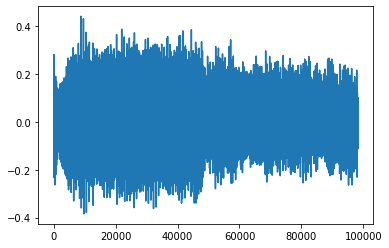

In [ ]:
wav_data = load_wav_16k_mono(filepath)

plt.plot(wav_data)

display.Audio(wav_data,rate=16000)

## YAMNet

### Loading YAMNet from TensorFlow Hub

In [ ]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

### Load the class mapping

[521 classes](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv)

In [ ]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])
print(class_names)

['Speech', 'Child speech, kid speaking', 'Conversation', 'Narration, monologue', 'Babbling', 'Speech synthesizer', 'Shout', 'Bellow', 'Whoop', 'Yell', 'Children shouting', 'Screaming', 'Whispering', 'Laughter', 'Baby laughter', 'Giggle', 'Snicker', 'Belly laugh', 'Chuckle, chortle', 'Crying, sobbing', 'Baby cry, infant cry', 'Whimper', 'Wail, moan', 'Sigh', 'Singing', 'Choir', 'Yodeling', 'Chant', 'Mantra', 'Child singing', 'Synthetic singing', 'Rapping', 'Humming', 'Groan', 'Grunt', 'Whistling', 'Breathing', 'Wheeze', 'Snoring', 'Gasp', 'Pant', 'Snort', 'Cough', 'Throat clearing', 'Sneeze', 'Sniff', 'Run', 'Shuffle', 'Walk, footsteps', 'Chewing, mastication', 'Biting', 'Gargling', 'Stomach rumble', 'Burping, eructation', 'Hiccup', 'Fart', 'Hands', 'Finger snapping', 'Clapping', 'Heart sounds, heartbeat', 'Heart murmur', 'Cheering', 'Applause', 'Chatter', 'Crowd', 'Hubbub, speech noise, speech babble', 'Children playing', 'Animal', 'Domestic animals, pets', 'Dog', 'Bark', 'Yip', 'Howl'

#### Change class

In [ ]:
drum_list = [157,158,159,160,161,162,163,164,166,167]
effect_list = [458,500,501,502,505,506,511]
hand_list = [56,57,58,62]
guitar_list = [135,136,137,138,139,140,141]
instrument_list = [133,134,142,143,144,145,146,156,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,208,396,495]
keyboard_list = [147,148,149,150,151,152,153,154,155]
noise_list = [507,508,514,515]
sound_list = [280,283,289,281]
style_list = [210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,496]
voice_list = [0,5,6,8,11,24,25,26,27,28,29,30,31,32,35,61]

### Run inference

1. 512 scores for every frames
2. Mean of each frames
3. Extract 20 best inference

In [ ]:
scores, embeddings, spectrogram = yamnet_model(wav_data)
class_scores = tf.reduce_mean(scores, axis=0)

top_value,top_index = tf.math.top_k(class_scores, k=20)
top_value,top_index = top_value.numpy(), top_index.numpy()
dic = dict(zip(top_index, top_value))

print([class_names[index] for index in top_index])

['Music', 'Keyboard (musical)', 'Piano', 'Musical instrument', 'Electric piano', 'Organ', 'New-age music', 'Tender music', 'Electronic organ', 'Lullaby', 'Classical music', 'Harp', 'Guitar', 'Plucked string instrument', 'Vibraphone', 'Synthesizer', 'Ambient music', 'Hammond organ', 'Steel guitar, slide guitar', 'Sad music']


In [ ]:
style_value,style_name = [],[]
instrument_value,instrument_name =[],[]
drum_value,drum_name =[],[]
effect_value,effect_name =[],[]
hand_value,hand_name =[],[]
guitar_value,guitar_name =[],[]
keyboard_value,keyboard_name =[],[]
noise_value,noise_name =[],[]
sound_value,sound_name =[],[]
voice_value,voice_name =[],[]
other_name = []
for i in top_index:
  if i in style_list:
    style_value.append(dic[i])
    style_name.append(class_names[i])
  elif i in drum_list :
    drum_value.append(dic[i])
    drum_name.append(class_names[i])
  elif i in effect_list :
    effect_value.append(dic[i])
    effect_name.append(class_names[i])
  elif i in hand_list :
    hand_value.append(dic[i])
    hand_name.append(class_names[i])
  elif i in keyboard_list :
    keyboard_value.append(dic[i])
    keyboard_name.append(class_names[i])
  elif i in noise_list :
    noise_value.append(dic[i])
    noise_name.append(class_names[i])
  elif i in sound_list :
    sound_value.append(dic[i])
    sound_name.append(class_names[i])
  elif i in voice_list :
    voice_value.append(dic[i])
    voice_name.append(class_names[i])
  elif i in guitar_list :
    guitar_value.append(dic[i])
    guitar_name.append(class_names[i])
  elif i in instrument_list :
    instrument_value.append(dic[i])
    instrument_name.append(class_names[i])
  else :
    other_name.append(class_names[i])

if style_name :
  print(f'The style is: {style_name}')
if drum_name :
  print(f'The drum is: {drum_name}')
if effect_name :
  print(f'The effect is: {effect_name}')
if hand_name :
  print(f'The hand is: {hand_name}')
if keyboard_name :
  print(f'The keyboard is: {keyboard_name}')
if noise_name :
  print(f'The noise is: {noise_name}')
if sound_name :
  print(f'The sound is: {sound_name}')
if voice_name :
  print(f'The voice is: {voice_name}')
if guitar_name :
  print(f'The guitar is: {guitar_name}')
if instrument_name :
  print(f'The instrument is: {instrument_name}')
if other_name :
  print(f'Other : {other_name}')

The style is: ['Jazz', 'Tender music', 'Blues', 'New-age music', 'Background music', 'Classical music']
The keyboard is: ['Keyboard (musical)', 'Piano', 'Electric piano', 'Organ', 'Electronic organ']
The guitar is: ['Guitar', 'Steel guitar, slide guitar', 'Electric guitar', 'Strum']
The instrument is: ['Musical instrument', 'Plucked string instrument', 'Brass instrument']
Other : ['Music', 'Silence']


#### Plot

In [ ]:
def plot(x,y):
  x_pos = np.arange(len(x))
  plt.bar(x_pos, y)
  plt.xticks(x_pos, x, rotation=90, color='white')
  plt.yticks(color='white')
  plt.subplots_adjust(bottom=0.4, top=0.99)

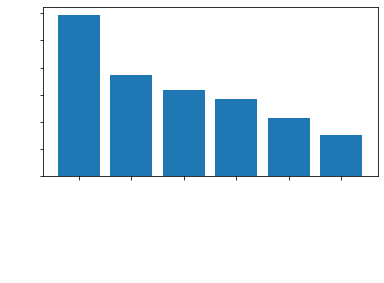

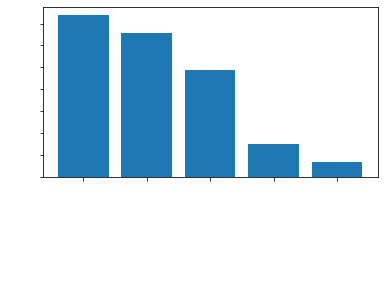

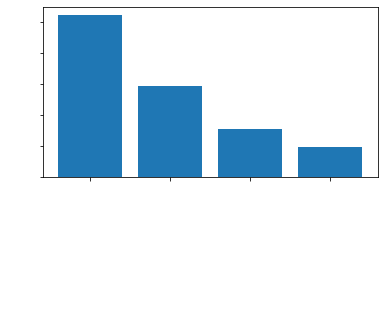

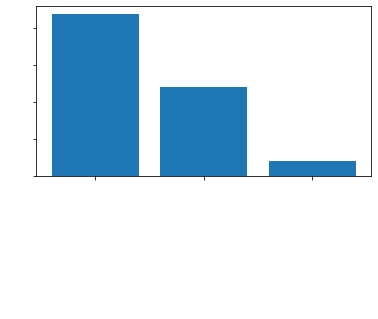

In [ ]:
if style_name :
  plt.figure(1)
  plot(style_value,style_name)
if drum_name :
  plt.figure(2)
  plot(drum_value,drum_name)
if effect_name :
  plt.figure(3)
  plot(effect_value,effect_name)
if hand_name :
  plt.figure(4)
  plot(hand_value,hand_name)
if keyboard_name :
  plt.figure(5)
  plot(keyboard_value,keyboard_name)
if noise_name :
  plt.figure(6)
  plot(noise_value,noise_name)
if sound_name :
  plt.figure(7)
  plot(sound_value,sound_name)
if voice_name :
  plt.figure(8)
  plot(voice_value,voice_name)
if guitar_name :
  plt.figure(9)
  plot(guitar_value,guitar_name)
if instrument_name :
  plt.figure(10)
  plot(instrument_value,instrument_name)
plt.show()